<a href="https://colab.research.google.com/github/nitinranjansharma/EVA5B2/blob/main/s10_workflow_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau

  pip install torch-lr-finder -v --global-option="amp"


In [2]:
import albumentations as A
import torchvision.transforms as transforms
import torch
from PIL import Image
from albumentations.pytorch import ToTensor
from plot_graph import plot_images, plot_graph
from utilities import *
from gradcam.visualize import VisualizeCam

In [3]:
## importing and transforming data
from read_inputs import read_transform_inputs
trainset, trainloader, testset, testloader, classes = read_transform_inputs()

Files already downloaded and verified
Files already downloaded and verified


truck horse horse  bird


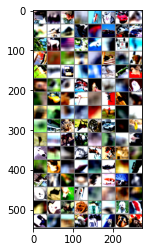

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
## defining model

from define_model import ResNet
from define_model import BasicBlock
from define_model import Bottleneck
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


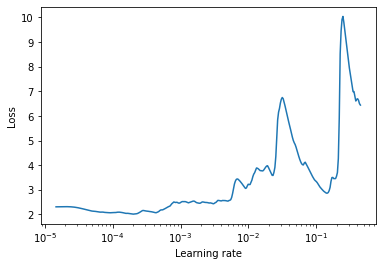

In [6]:
##defining optimiser
from define_optim import optim_define
criterion = nn.CrossEntropyLoss()
optimizer = optim_define(model)
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, val_loader=testloader, start_lr=1e-5, end_lr=2,
                     num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [8]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))


Best Loss: 2.0114193363233173
Best Learning Rate: 0.0002002311590646604


In [12]:
from train import train
from test import test
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
#scheduler = OneCycleLR(optimizer, max_lr=0.1, epochs=epochs,
#                      steps_per_epoch=len(trainloader))
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,
                             verbose=True, min_lr=1e-5)
epochs = 50
def run(l1_decay=0.0, l2_decay=0.0):
  test_losses = []
  test_accs = []
  train_losses = []
  train_accs = []
  misclassified_imgs = []
  correct_imgs = []
  for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch,
            l1_decay,l2_decay, train_losses, train_accs)
      
      test(model, device, testloader, criterion, classes, test_losses, test_accs,
           misclassified_imgs, correct_imgs, epoch==epochs-1)
      scheduler.step(test_losses[-1])
  return train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs

# train and test the model
train_losses, train_accs, test_losses, test_accs, misclassified_imgs, correct_imgs = run(l1_decay=3e-6, l2_decay=1e-3)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


L2_loss=458.0498962402344 L1_loss=107928.0546875 Loss=2.3964531421661377 Batch_id=390 Accuracy=40.47: 100%|██████████| 391/391 [01:00<00:00,  6.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0111, Accuracy: 4938/10000 (49.38%)

EPOCH: 2


L2_loss=457.8358459472656 L1_loss=107387.7734375 Loss=2.0482327938079834 Batch_id=390 Accuracy=47.86: 100%|██████████| 391/391 [01:02<00:00,  6.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0092, Accuracy: 5875/10000 (58.75%)

EPOCH: 3


L2_loss=457.6060485839844 L1_loss=106853.59375 Loss=2.014835834503174 Batch_id=390 Accuracy=51.37: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 5481/10000 (54.81%)

EPOCH: 4


L2_loss=457.3312072753906 L1_loss=106308.0234375 Loss=2.074993133544922 Batch_id=390 Accuracy=53.95: 100%|██████████| 391/391 [01:05<00:00,  5.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0086, Accuracy: 6135/10000 (61.35%)

EPOCH: 5


L2_loss=457.0286560058594 L1_loss=105756.03125 Loss=2.1640422344207764 Batch_id=390 Accuracy=55.77: 100%|██████████| 391/391 [01:04<00:00,  6.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0078, Accuracy: 6491/10000 (64.91%)

EPOCH: 6


L2_loss=456.7137756347656 L1_loss=105218.7578125 Loss=1.9211995601654053 Batch_id=390 Accuracy=57.80: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0075, Accuracy: 6718/10000 (67.18%)

EPOCH: 7


L2_loss=456.3247375488281 L1_loss=104686.859375 Loss=1.7503907680511475 Batch_id=390 Accuracy=59.04: 100%|██████████| 391/391 [01:05<00:00,  5.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0068, Accuracy: 6975/10000 (69.75%)

EPOCH: 8


L2_loss=455.92120361328125 L1_loss=104166.9609375 Loss=2.006649971008301 Batch_id=390 Accuracy=60.57: 100%|██████████| 391/391 [01:06<00:00,  5.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0065, Accuracy: 7083/10000 (70.83%)

EPOCH: 9


L2_loss=455.54608154296875 L1_loss=103659.3125 Loss=1.750605583190918 Batch_id=390 Accuracy=61.57: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0074, Accuracy: 6640/10000 (66.40%)

EPOCH: 10


L2_loss=455.16046142578125 L1_loss=103168.4765625 Loss=1.8596941232681274 Batch_id=390 Accuracy=61.97: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 7187/10000 (71.87%)

EPOCH: 11


L2_loss=454.74725341796875 L1_loss=102688.90625 Loss=1.811472773551941 Batch_id=390 Accuracy=63.33: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 7300/10000 (73.00%)

EPOCH: 12


L2_loss=454.3245544433594 L1_loss=102212.9140625 Loss=1.7861603498458862 Batch_id=390 Accuracy=64.15: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0061, Accuracy: 7342/10000 (73.42%)

EPOCH: 13


L2_loss=453.91876220703125 L1_loss=101750.2265625 Loss=1.8183516263961792 Batch_id=390 Accuracy=65.04: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0064, Accuracy: 7258/10000 (72.58%)

EPOCH: 14


L2_loss=453.4526672363281 L1_loss=101280.0625 Loss=1.549824833869934 Batch_id=390 Accuracy=66.11: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 7584/10000 (75.84%)

EPOCH: 15


L2_loss=452.984130859375 L1_loss=100825.3359375 Loss=1.5859346389770508 Batch_id=390 Accuracy=66.55: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0056, Accuracy: 7567/10000 (75.67%)

EPOCH: 16


L2_loss=452.4869689941406 L1_loss=100380.8125 Loss=1.7838387489318848 Batch_id=390 Accuracy=66.62: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7572/10000 (75.72%)

EPOCH: 17


L2_loss=452.0093078613281 L1_loss=99947.40625 Loss=1.6455565690994263 Batch_id=390 Accuracy=67.98: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7584/10000 (75.84%)

EPOCH: 18


L2_loss=451.5419616699219 L1_loss=99528.3046875 Loss=1.415544033050537 Batch_id=390 Accuracy=68.26: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0050, Accuracy: 7817/10000 (78.17%)

EPOCH: 19


L2_loss=451.0848388671875 L1_loss=99135.6328125 Loss=1.7510212659835815 Batch_id=390 Accuracy=68.71: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0053, Accuracy: 7640/10000 (76.40%)

EPOCH: 20


L2_loss=450.5802001953125 L1_loss=98725.1484375 Loss=1.471492052078247 Batch_id=390 Accuracy=69.30: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7788/10000 (77.88%)

EPOCH: 21


L2_loss=450.0811767578125 L1_loss=98337.109375 Loss=1.714875340461731 Batch_id=390 Accuracy=69.46: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7876/10000 (78.76%)

EPOCH: 22


L2_loss=449.55181884765625 L1_loss=97936.4765625 Loss=1.7764477729797363 Batch_id=390 Accuracy=69.97: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7815/10000 (78.15%)

EPOCH: 23


L2_loss=449.0465087890625 L1_loss=97561.125 Loss=1.8990846872329712 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0051, Accuracy: 7826/10000 (78.26%)

EPOCH: 24


L2_loss=448.5115051269531 L1_loss=97189.3046875 Loss=1.6628024578094482 Batch_id=390 Accuracy=70.84: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0044, Accuracy: 8064/10000 (80.64%)

EPOCH: 25


L2_loss=448.0157775878906 L1_loss=96830.2109375 Loss=1.616115927696228 Batch_id=390 Accuracy=70.97: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 7947/10000 (79.47%)

EPOCH: 26


L2_loss=447.4770202636719 L1_loss=96475.203125 Loss=1.568208932876587 Batch_id=390 Accuracy=71.42: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0049, Accuracy: 7986/10000 (79.86%)

EPOCH: 27


L2_loss=446.9440002441406 L1_loss=96131.109375 Loss=1.4031177759170532 Batch_id=390 Accuracy=71.92: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8145/10000 (81.45%)

EPOCH: 28


L2_loss=446.4017639160156 L1_loss=95788.546875 Loss=1.480839490890503 Batch_id=390 Accuracy=72.07: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8141/10000 (81.41%)

EPOCH: 29


L2_loss=445.8514404296875 L1_loss=95459.984375 Loss=1.6458287239074707 Batch_id=390 Accuracy=72.33: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0047, Accuracy: 7969/10000 (79.69%)

EPOCH: 30


L2_loss=445.27642822265625 L1_loss=95128.296875 Loss=1.4280025959014893 Batch_id=390 Accuracy=72.56: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8167/10000 (81.67%)

EPOCH: 31


L2_loss=444.7424621582031 L1_loss=94806.328125 Loss=1.5066834688186646 Batch_id=390 Accuracy=73.14: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 7979/10000 (79.79%)

EPOCH: 32


L2_loss=444.13885498046875 L1_loss=94482.46875 Loss=1.6792317628860474 Batch_id=390 Accuracy=73.42: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0041, Accuracy: 8261/10000 (82.61%)

EPOCH: 33


L2_loss=443.62158203125 L1_loss=94193.890625 Loss=1.4616904258728027 Batch_id=390 Accuracy=73.33: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8179/10000 (81.79%)

EPOCH: 34


L2_loss=443.052734375 L1_loss=93900.625 Loss=1.6999591588974 Batch_id=390 Accuracy=73.91: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0040, Accuracy: 8272/10000 (82.72%)

EPOCH: 35


L2_loss=442.51153564453125 L1_loss=93617.453125 Loss=1.5473337173461914 Batch_id=390 Accuracy=73.97: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 8121/10000 (81.21%)

EPOCH: 36


L2_loss=441.9913024902344 L1_loss=93353.1640625 Loss=1.487563133239746 Batch_id=390 Accuracy=74.15: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8228/10000 (82.28%)

EPOCH: 37


L2_loss=441.4572448730469 L1_loss=93080.046875 Loss=1.569463849067688 Batch_id=390 Accuracy=74.36: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0045, Accuracy: 8102/10000 (81.02%)

EPOCH: 38


L2_loss=440.90826416015625 L1_loss=92823.046875 Loss=1.4678518772125244 Batch_id=390 Accuracy=74.55: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8199/10000 (81.99%)

Epoch    38: reducing learning rate of group 0 to 7.2553e-04.
EPOCH: 39


L2_loss=440.7100524902344 L1_loss=92708.3671875 Loss=1.3066051006317139 Batch_id=390 Accuracy=77.93: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0033, Accuracy: 8586/10000 (85.86%)

EPOCH: 40


L2_loss=440.51025390625 L1_loss=92597.09375 Loss=1.2051690816879272 Batch_id=390 Accuracy=78.65: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8609/10000 (86.09%)

EPOCH: 41


L2_loss=440.31414794921875 L1_loss=92488.5859375 Loss=1.331162691116333 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8651/10000 (86.51%)

EPOCH: 42


L2_loss=440.12042236328125 L1_loss=92381.6015625 Loss=1.4496934413909912 Batch_id=390 Accuracy=79.17: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8632/10000 (86.32%)

EPOCH: 43


L2_loss=439.9308166503906 L1_loss=92277.0859375 Loss=1.3928431272506714 Batch_id=390 Accuracy=79.80: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0032, Accuracy: 8664/10000 (86.64%)

EPOCH: 44


L2_loss=439.744873046875 L1_loss=92173.4609375 Loss=1.3205938339233398 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8666/10000 (86.66%)

EPOCH: 45


L2_loss=439.5577087402344 L1_loss=92070.4765625 Loss=1.1499276161193848 Batch_id=390 Accuracy=79.93: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8692/10000 (86.92%)

EPOCH: 46


L2_loss=439.3748474121094 L1_loss=91969.1484375 Loss=1.3722317218780518 Batch_id=390 Accuracy=80.31: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8648/10000 (86.48%)

EPOCH: 47


L2_loss=439.18939208984375 L1_loss=91868.3203125 Loss=1.3567143678665161 Batch_id=390 Accuracy=80.13: 100%|██████████| 391/391 [01:06<00:00,  5.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8676/10000 (86.76%)

EPOCH: 48


L2_loss=439.00592041015625 L1_loss=91768.78125 Loss=1.2241671085357666 Batch_id=390 Accuracy=80.42: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0031, Accuracy: 8637/10000 (86.37%)

EPOCH: 49


L2_loss=438.83099365234375 L1_loss=91669.2890625 Loss=1.226693034172058 Batch_id=390 Accuracy=80.75: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0030, Accuracy: 8706/10000 (87.06%)

EPOCH: 50


L2_loss=438.6513977050781 L1_loss=91571.0546875 Loss=1.3939533233642578 Batch_id=390 Accuracy=80.79: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s]


Test set: Average loss: 0.0031, Accuracy: 8642/10000 (86.42%)



GroundTruth:    cat  ship  ship plane


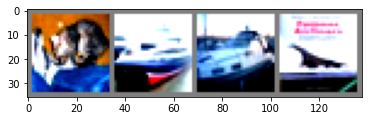

In [13]:
## checking test images

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

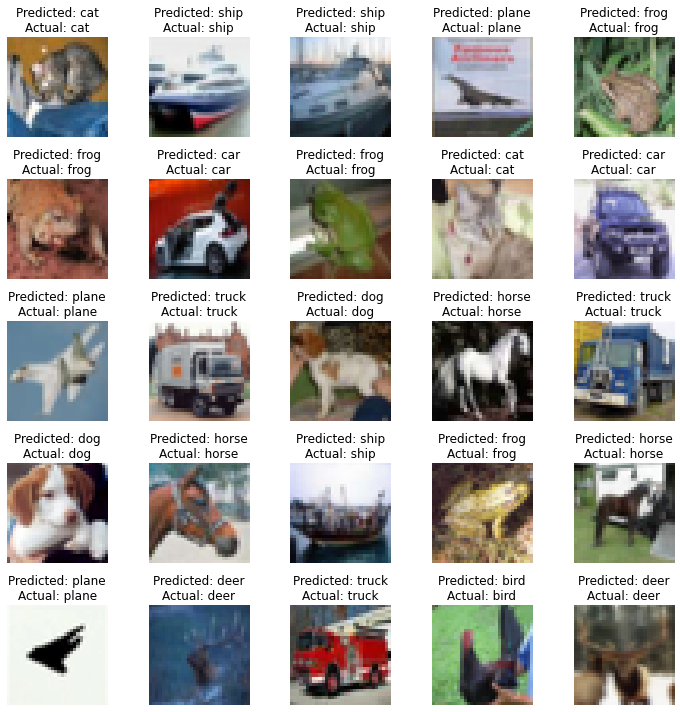

In [14]:
## correct images
plot_images(correct_imgs, classes, "correct_imgs.png")

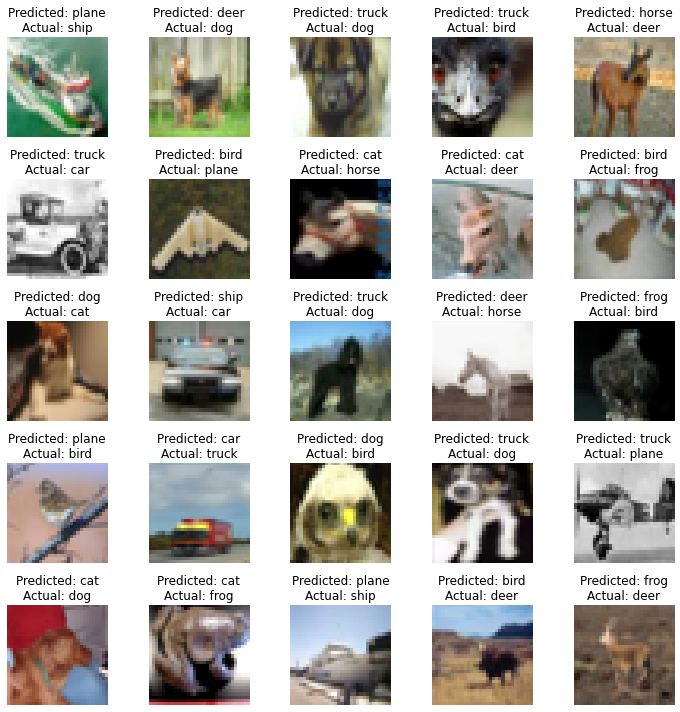

In [15]:
plot_images(misclassified_imgs, classes, "misclassified_imgs.png")

In [16]:
from accuracy_check import check_accuracy     
check_accuracy(testloader,device,model)

Accuracy of the network on the 10000 test images: 86 %


86.42

In [17]:
torch.save(model,"model_2.sav")

In [18]:
from gradcam.visualize import VisualizeCam

In [19]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(model,classes, target_layers)

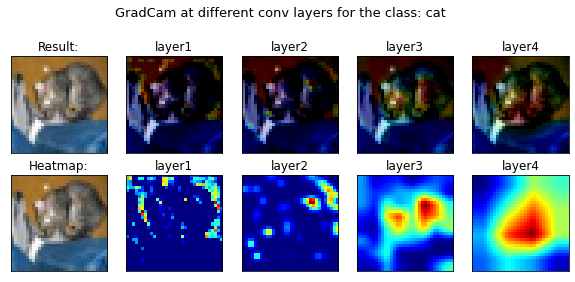

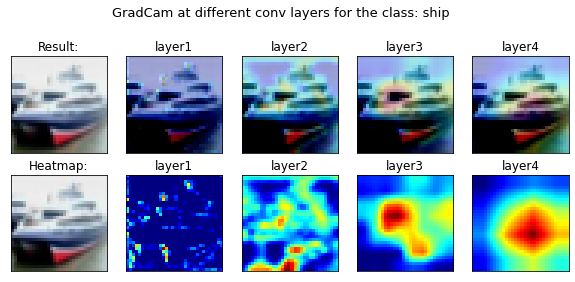

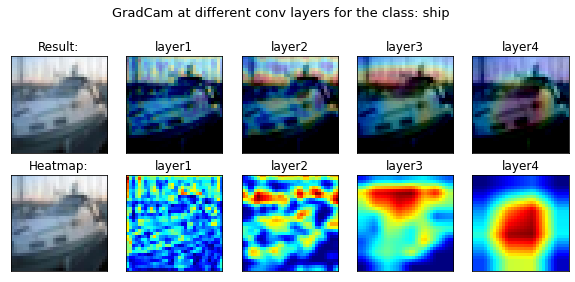

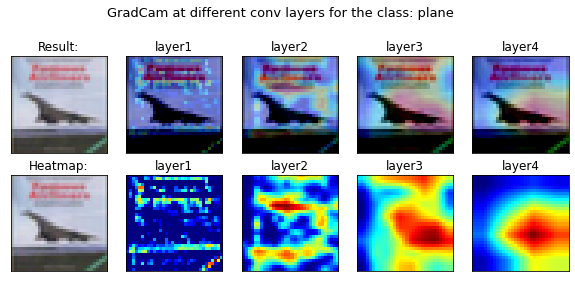

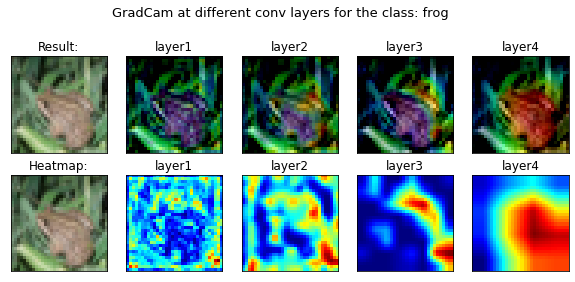

In [20]:
##Correct Images
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

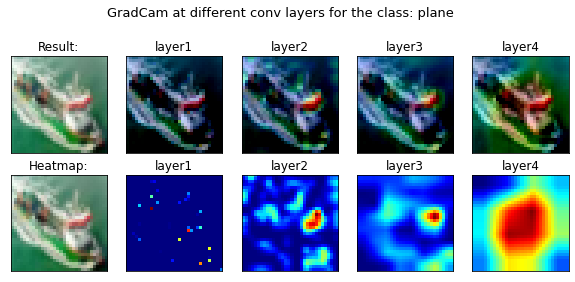

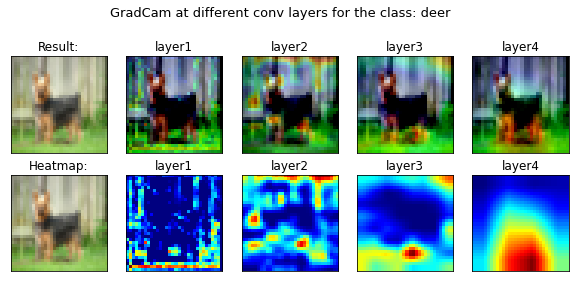

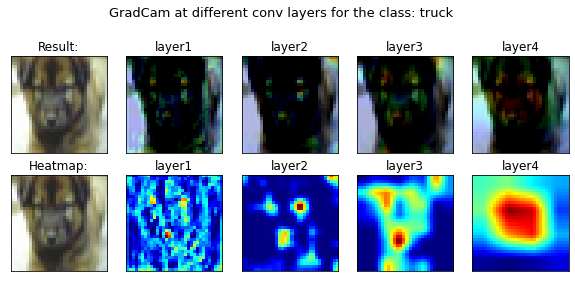

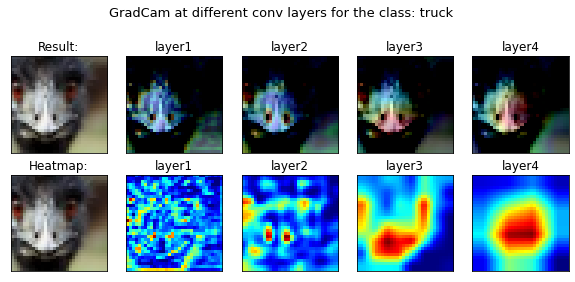

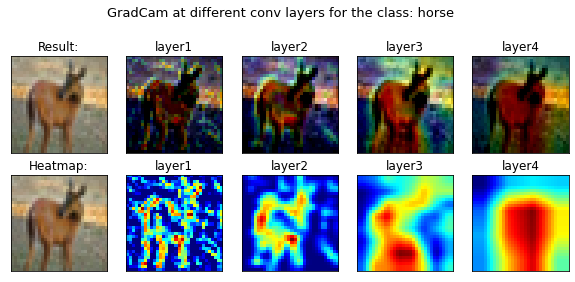

In [21]:
##Misclassfied
incorrect_pred_imgs = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")